# Visualize and store covariate ranges

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [24]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning
import os
import pickle
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import kruskal
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 




#--- Notebook run settings
climate_data_list  = ['CRUclim','CRUNCEPv7','CHELSA30s','WorldClim30s','WorldClim10m',]
climate_data       = climate_data_list[1]
remove_data        = True

In [25]:
#---------------#
#  Import data  #
#---------------#

cols = ['MAT','DBH mean','Dominant_mortality cause','MTF basis','Continent','Fire','MTF','Managed',
        'Mortality','PFT','Country','Region','Site name','Reference']

#--- Site MTF
site_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Site_MTF')
site_mtf.loc[site_mtf['Site name'].isna(),'Site name'] = ''
site_mtf.loc[site_mtf['Y coords'].isna(),'Y coords'] = ''
site_mtf.loc[site_mtf['X coords'].isna(),'X coords'] = ''
site_mtf['MAT'] = site_mtf[(climate_data,'MAT')]
site_mtf_cp = site_mtf.copy()
site_mtf = site_mtf.loc[site_mtf['MTF basis'] == 'count', cols]
site_mtf.columns = site_mtf.columns.get_level_values(0)

#--- Species
species_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Species_MTF')
species_mtf.loc[species_mtf['Site name'].isna(),'Site name'] = ''
species_mtf.loc[species_mtf['Y coords'].isna(),'Y coords'] = ''
species_mtf.loc[species_mtf['X coords'].isna(),'X coords'] = ''
species_mtf['MAT'] = species_mtf[(climate_data,'MAT')]
species_mtf_cp = species_mtf.copy()
species_mtf = species_mtf.loc[species_mtf['MTF basis'] == 'count', cols+['Species']]
species_mtf.columns = species_mtf.columns.get_level_values(0)

In [26]:
site_mtf.columns

Index(['MAT', 'DBH mean', 'Dominant_mortality cause', 'MTF basis', 'Continent',
       'Fire', 'MTF', 'Managed', 'Mortality', 'PFT', 'Country', 'Region',
       'Site name', 'Reference'],
      dtype='object')

In [27]:
#---------------#
#  Import data  #
#---------------#

data = [site_mtf, species_mtf]
    
#--------------------#
#   Transform data   #
#--------------------#

for i,mtf in enumerate(data):
    print(len(mtf))
    if remove_data:    
        mtf = mtf[~(mtf.Reference == 'Ritchie2014EstablishmentForest')].copy()
        mtf = mtf[~(mtf.Reference == 'Campbell2016CarbonStates')].copy()

    mtf.loc[:, 'MTF'] = mtf.loc[:, 'MTF'].apply(np.log) # necessary to fullfill normality of the residuals requirement of multiple regression and ANCOVA
    
    data[i] = mtf
    #print(len(mtf))

87
151



#---------------#
#   Figure B3   #
#---------------#


 MAT & DBH subset
N Fire mort: 20
N Insect mort: 11
N Other mort: 39

 MAT & DBH subset
N Fire mort: 37
N Insect mort: 9
N Other mort: 61


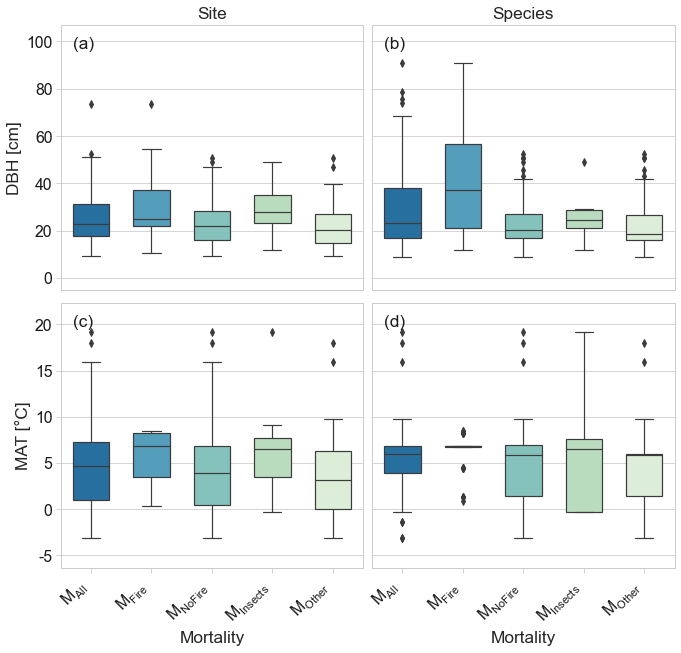

In [28]:
bd.print_header('Figure B3')
var_list   = ['DBH mean', 'MAT']
mort_order = ['All','Fire','No Fire', 'Insects', 'Other']
mort_order_store = ['M_All','M_Fire','M_NoFire', 'M_Insects', 'M_Other']
mort_plot  = ['$M_{All}$','$M_{Fire}$','$M_{No Fire}$', '$M_{Insects}$', '$M_{Other}$']
fac = 0.8


data_mort = np.empty((2,),dtype='object')

# Plot settings
sns.set_context("paper", font_scale=1.8)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'

fig, ax = plt.subplots(len(var_list),2, figsize=(11,10),sharex=True)


for i,mtf in enumerate(data):

    if i == 0:
        mtf = mtf.dropna(subset=['MAT','DBH mean']).copy()
    else:
        mtf = mtf.dropna(subset=['MAT','DBH mean','Managed', 'PFT']).copy()
    print('\n MAT & DBH subset')    
    print('N Fire mort: {}'.format(len(mtf[(mtf['MTF basis'] == 'count') & (mtf['Mortality'] == 'Fire')])))
    print('N Insect mort: {}'.format(len(mtf[(mtf['MTF basis'] == 'count') & (mtf['Mortality'] == 'Insects')])))
    print('N Other mort: {}'.format(len(mtf[(mtf['MTF basis'] == 'count') & (mtf['Mortality'] == 'Other')])))
    
    #--- Boxplotting mortality group - 
    #    appending the entire DF (axis=0) setting Mortality to 'ALL' to compare data of Mortality selections

    mtf_all_mort_copy = mtf.copy()
    mtf_all_mort_copy['Mortality'] = 'All'
    
    if i == 0: # At site level for all mortality, management is a covariate, so subsetting data
        mtf_all_mort_copy = mtf_all_mort_copy[mtf_all_mort_copy.Managed.notna()]
    
    mtf_no_fire_mort  = mtf.copy()
    mtf_no_fire_mort.loc[(mtf_no_fire_mort.Fire == 0), 'Mortality'] = 'No Fire'
    mtf_no_fire_mort  = mtf_no_fire_mort[mtf_no_fire_mort.Mortality == 'No Fire']
    
    
    
    mtf_mort_extended = pd.concat([mtf,
                                   mtf_all_mort_copy,
                                   mtf_no_fire_mort],axis=0)
    
    data_mort[i] = mtf_mort_extended
    
    for v,var in enumerate(var_list):
        g = sns.boxplot(data=mtf_mort_extended, 
                    #hue='MTF basis', 
                    x='Mortality',
                    y=var, 
                    width=0.6, 
                    palette=sns.color_palette("GnBu_r",5),
                    order=mort_order,
                    ax=ax[v,i])
        
        ax[v,i].legend([],[], frameon=False)
        ax[v,i].set_xlabel(None)
        if i == 1:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax[v,i].set_ylabel(None) 
                ax[v,i].yaxis.set_ticks_position('none') 
                ax[v,i].set_yticklabels(ax[v,i].get_yticklabels(),color='#FF000000' )
        if v < (len(var_list)-1):
            ax[v,i].xaxis.set_ticks_position('none') 
        
ax[0,0].set_title('Site')
ax[0,1].set_title('Species') 
ax[1,0].set_xlabel('Mortality') 
ax[1,1].set_xlabel('Mortality') 
ax[0,0].set_ylabel('DBH [cm]') 
ax[1,0].set_ylabel('MAT [°C]') 
ax[len(var_list)-1,0].set_xticklabels(mort_order, rotation = 45, ha="right")
ax[len(var_list)-1,1].set_xticklabels(mort_order, rotation = 45, ha="right")

y_max = [102,21,4]
y_min = [0,-5.1,0]
# Adjust yrange
for j in range(2):
    for i in range(2):
        pts = ax[j,i].dataLim.get_points()  # numpy array [[xmin, ymin], [xmax, ymax]]
        pts[1, 1] = y_max[j]  # new ymax
        pts[0, 1] = y_min[j]  # new ymin
        ax[j,i].dataLim.set_points(pts)
        ax[j,i].autoscale_view()
    
ax[0,0].annotate(xy=(-0.3,97),text='(a)',color='k')
ax[0,1].annotate(xy=(-0.3,97),text='(b)',color='k')

ax[1,0].annotate(xy=(-0.3,19.8),text='(c)',color='k')
ax[1,1].annotate(xy=(-0.3,19.8),text='(d)',color='k')


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0,0].set_yticklabels(np.arange(-20,120,20),color='k')
    ax[1,0].set_yticklabels(np.arange(-10,25,5),color='k')
    ax[1,0].set_xticklabels(mort_plot, color='k')
    ax[1,1].set_xticklabels(mort_plot, color='k')
plt.subplots_adjust(wspace=0.03,hspace=0.05)
plt.savefig('Appendix_FigureB3_regression_covariates_mortality_group.png', dpi=300, bbox_inches='tight')
plt.show()

## Mean and range of covariates

In [29]:
cov_vars = ['MTF','DBH mean','MAT','PFT']
level_option_list = ['Site','Species']

df_clim_stats       = pd.DataFrame() # Paper
df_clim_stats_store = pd.DataFrame() # Storage

for m,mtf_mort_extended in enumerate(data_mort):

    clim_stats_mean = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').mean()[
                            cov_vars].round(2)
    clim_stats_min  = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').min()[
                            cov_vars].round(1)
    clim_stats_max  = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').max()[
                            cov_vars].round(1)
    clim_stats_n    = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').count()['MTF']
    index_data = clim_stats_n.index.to_list()
    clim_stats_n = clim_stats_n.to_frame().T[mort_order].T
    #print(clim_stats_n.index)
    clim_stats = pd.DataFrame()
    
    # Table for paper
    for i,j in enumerate(cov_vars):
        mean = clim_stats_mean[j].to_list()
        max_ = clim_stats_max[j].to_list()
        min_ = clim_stats_min[j].to_list()
        
        if (j == 'MTF'):
            mean = np.round(np.exp(mean))
            min_ = np.round(np.exp(min_))
            max_ = np.round(np.exp(max_))
        
        if j == 'PFT':
            clim_stats[j] = mean
        else:
            clim_stats[j] = [str(a)+' ('+str(m)+'—'+str(o)+')' for a,o,m in zip(mean,max_,min_)]
    
    clim_stats.index = index_data
    #display(clim_stats)
    clim_stats = clim_stats.T[mort_order].T
    clim_stats['Nobs'] = clim_stats_n
    #display(clim_stats)
    clim_stats.index = mort_order_store

    idx_mult = pd.MultiIndex.from_tuples((level_option_list[m],j) for j in clim_stats.index.to_list())
    clim_stats.index = idx_mult
    
    df_clim_stats = pd.concat([df_clim_stats,clim_stats])
    
    
    # Table for testing models for difference (min - max)
    idx_mult_min  = pd.MultiIndex.from_tuples((level_option_list[m],'Min',j) for j in clim_stats_min.index.to_list())
    idx_mult_max  = pd.MultiIndex.from_tuples((level_option_list[m],'Max',j) for j in clim_stats_min.index.to_list())
    idx_mult_mean = pd.MultiIndex.from_tuples((level_option_list[m],'Mean',j) for j in clim_stats_min.index.to_list())
    
    clim_stats_min.index  = idx_mult_min
    clim_stats_max.index  = idx_mult_max
    clim_stats_mean.index = idx_mult_mean
    
    df_clim_stats_store = pd.concat([df_clim_stats_store, clim_stats_min,clim_stats_max,clim_stats_mean])
    
display(df_clim_stats)
print(df_clim_stats.to_latex())   

MTF           DBH mean               MAT  \
Site    M_All      17.0 (3.0—148.0)   26.07 (9.4—73.6)  4.71 (-3.1—19.2)   
        M_Fire     17.0 (4.0—110.0)  31.13 (10.4—73.6)    5.74 (0.3—8.5)   
        M_NoFire   16.0 (3.0—148.0)    24.0 (9.4—50.9)  4.32 (-3.1—19.2)   
        M_Insects    9.0 (5.0—27.0)  28.59 (11.7—49.0)  6.45 (-0.3—19.2)   
        M_Other    18.0 (3.0—148.0)   22.71 (9.4—50.9)  3.71 (-3.1—18.0)   
Species M_All      17.0 (2.0—299.0)   29.02 (8.9—91.1)  5.41 (-3.1—19.2)   
        M_Fire     27.0 (6.0—299.0)  39.49 (11.9—91.1)    6.19 (0.9—8.5)   
        M_NoFire    13.0 (2.0—74.0)   23.48 (8.9—52.4)  4.99 (-3.1—19.2)   
        M_Insects   11.0 (7.0—37.0)  25.83 (11.7—49.0)  6.18 (-0.3—19.2)   
        M_Other     14.0 (2.0—74.0)   23.13 (8.9—52.4)  4.81 (-3.1—18.0)   

                    PFT  Nobs  
Site    M_All      0.92    64  
        M_Fire      1.0    20  
        M_NoFire    0.9    50  
        M_Insects  0.91    11  
        M_Other     0.9    39  
Species M_All      0.77   107  
        M_Fire     0.97    37  
        M_NoFire   0.66    70  
        M_Insects  0.89     9  
        M_Other    0.62    61

\begin{tabular}{llllllr}
\toprule
        &         &               MTF &           DBH mean &               MAT &   PFT &  Nobs \\
\midrule
Site & M\_All &  17.0 (3.0—148.0) &   26.07 (9.4—73.6) &  4.71 (-3.1—19.2) &  0.92 &    64 \\
        & M\_Fire &  17.0 (4.0—110.0) &  31.13 (10.4—73.6) &    5.74 (0.3—8.5) &   1.0 &    20 \\
        & M\_NoFire &  16.0 (3.0—148.0) &    24.0 (9.4—50.9) &  4.32 (-3.1—19.2) &   0.9 &    50 \\
        & M\_Insects &    9.0 (5.0—27.0) &  28.59 (11.7—49.0) &  6.45 (-0.3—19.2) &  0.91 &    11 \\
        & M\_Other &  18.0 (3.0—148.0) &   22.71 (9.4—50.9) &  3.71 (-3.1—18.0) &   0.9 &    39 \\
Species & M\_All &  17.0 (2.0—299.0) &   29.02 (8.9—91.1) &  5.41 (-3.1—19.2) &  0.77 &   107 \\
        & M\_Fire &  27.0 (6.0—299.0) &  39.49 (11.9—91.1) &    6.19 (0.9—8.5) &  0.97 &    37 \\
        & M\_NoFire &   13.0 (2.0—74.0) &   23.48 (8.9—52.4) &  4.99 (-3.1—19.2) &  0.66 &    70 \\
        & M\_Insects &   11.0 (7.0—37.0) &  25.83 (11.7—49.0) &  6.18 (-

In [30]:
bd.print_header('Table A2')
managed_covariates = pd.DataFrame()

for l,data in enumerate(data_mort): # site- and species-level
    data = data.dropna(subset=['DBH mean','PFT','MAT','Managed']).copy()
    data = data[(data['MTF basis'] == 'count')].copy()
    managed_mean = data.groupby(['Managed','Mortality']).mean().round(2)
    cols = managed_mean.columns
    managed_min  = data.groupby(['Managed','Mortality'])[cols].min().round(1)
    managed_max  = data.groupby(['Managed','Mortality'])[cols].max().round(1)
    var_list = managed_mean.columns.to_list()

    for v,var in enumerate(var_list):
        
        if var == 'MTF':
            managed_mean[var] = managed_mean[var].apply(np.exp).round()
            managed_min[var] = managed_min[var].apply(np.exp).round() 
            managed_max[var] = managed_max[var].apply(np.exp).round()            
        
        for i in range(len(managed_mean)):
            
            if var == 'PFT':
                managed_mean.iloc[i,v] = str(managed_mean.iloc[i,v])
            
            else:

                managed_mean.iloc[i,v] = (str(managed_mean.iloc[i,v])+' ('+
                                           str(managed_min.iloc[i,v])+'–'+
                                           str(managed_max.iloc[i,v])+')'
                                          )
    
    managed_mean.loc[:,'level'] = level_option_list[l]
    managed_mean.loc[:,'n'] = data.groupby(['Managed','Mortality']).count()['Reference']
    managed_mean.reset_index(inplace=True)
    
    managed_covariates = pd.concat([managed_covariates,managed_mean])
managed_covariates.loc[(managed_covariates.Managed == 0), 'Managed'] = 'No'
managed_covariates.loc[(managed_covariates.Managed == 1), 'Managed'] = 'Yes'
managed_covariates.set_index(['level','Mortality','Managed'], inplace=True)
managed_covariates.sort_index(inplace=True)
managed_covariates = managed_covariates[['MTF','DBH mean','MAT','PFT','n']]
display(managed_covariates)
print(managed_covariates.to_latex())


#--------------#
#   Table A2   #
#--------------#



MTF           DBH mean  \
level   Mortality Managed                                        
Site    All       No       22.0 (4.0–148.0)    25.5 (9.4–73.6)   
                  Yes        9.0 (3.0–49.0)  27.52 (14.7–49.0)   
        Fire      No       20.0 (4.0–110.0)   32.1 (14.5–73.6)   
                  Yes         7.0 (7.0–7.0)  14.73 (14.7–14.7)   
        Insects   No        10.0 (7.0–18.0)  27.52 (11.7–35.4)   
                  Yes        9.0 (7.0–27.0)  29.81 (21.9–49.0)   
        No Fire   No       22.0 (7.0–148.0)   21.98 (9.4–50.9)   
                  Yes        9.0 (3.0–49.0)  28.27 (18.7–49.0)   
        Other     No       26.0 (8.0–148.0)   20.87 (9.4–50.9)   
                  Yes        9.0 (3.0–49.0)  27.63 (18.7–46.9)   
Species All       No       22.0 (4.0–299.0)   30.44 (8.9–91.1)   
                  Yes        9.0 (2.0–49.0)  25.69 (14.7–52.4)   
        Fire      No       28.0 (6.0–299.0)  40.18 (11.9–91.1)   
                  Yes         7.0 (7.0–7.0)  14.73 (14.7–14.7)   
        Insects   No        10.0 (9.0–11.0)  15.84 (11.7–20.0)   
                  Yes       11.0 (7.0–37.0)  28.68 (21.1–49.0)   
        No Fire   No        18.0 (4.0–74.0)   21.44 (8.9–50.9)   
                  Yes       10.0 (2.0–49.0)  26.04 (16.6–52.4)   
        Other     No        18.0 (4.0–74.0)   21.74 (8.9–50.9)   
                  Yes        9.0 (2.0–49.0)  25.27 (16.6–52.4)   

                                        MAT   PFT   n  
level   Mortality Managed                              
Site    All       No        3.95 (-3.1–9.8)  0.93  46  
                  Yes      6.66 (-0.3–19.2)  0.89  18  
        Fire      No         5.81 (0.3–8.5)   1.0  16  
                  Yes         0.9 (0.9–0.9)   1.0   1  
        Insects   No         5.82 (1.0–9.1)   0.8   5  
                  Yes       6.8 (-0.3–19.2)   1.0   5  
        No Fire   No        2.96 (-3.1–9.8)   0.9  30  
                  Yes       7.0 (-0.3–19.2)  0.88  17  
        Other     No        2.38 (-3.1–9.8)  0.92  25  
                  Yes       7.08 (3.1–18.0)  0.83  12  
Species All       No        4.93 (-3.1–9.8)  0.87  75  
                  Yes      6.51 (-0.3–19.2)  0.53  32  
        Fire      No         6.34 (1.3–8.5)  0.97  36  
                  Yes         0.9 (0.9–0.9)   1.0   1  
        Insects   No          7.8 (6.5–9.1)   0.5   2  
                  Yes      5.71 (-0.3–19.2)   1.0   7  
        No Fire   No        3.64 (-3.1–9.8)  0.77  39  
                  Yes      6.69 (-0.3–19.2)  0.52  31  
        Other     No        3.41 (-3.1–9.8)  0.78  37  
                  Yes       6.98 (3.1–18.0)  0.38  24

\begin{tabular}{lllllllr}
\toprule
        &       &     &               MTF &           DBH mean &               MAT &   PFT &   n \\
level & Mortality & Managed &                   &                    &                   &       &     \\
\midrule
Site & All & No &  22.0 (4.0–148.0) &    25.5 (9.4–73.6) &   3.95 (-3.1–9.8) &  0.93 &  46 \\
        &       & Yes &    9.0 (3.0–49.0) &  27.52 (14.7–49.0) &  6.66 (-0.3–19.2) &  0.89 &  18 \\
        & Fire & No &  20.0 (4.0–110.0) &   32.1 (14.5–73.6) &    5.81 (0.3–8.5) &   1.0 &  16 \\
        &       & Yes &     7.0 (7.0–7.0) &  14.73 (14.7–14.7) &     0.9 (0.9–0.9) &   1.0 &   1 \\
        & Insects & No &   10.0 (7.0–18.0) &  27.52 (11.7–35.4) &    5.82 (1.0–9.1) &   0.8 &   5 \\
        &       & Yes &    9.0 (7.0–27.0) &  29.81 (21.9–49.0) &   6.8 (-0.3–19.2) &   1.0 &   5 \\
        & No Fire & No &  22.0 (7.0–148.0) &   21.98 (9.4–50.9) &   2.96 (-3.1–9.8) &   0.9 &  30 \\
        &       & Yes &    9.0 (3.0–49.0) &  28.27 (18.7